Current directory: c:\Users\juanj\Documents\Github\ComputacionVisual\2025-05-03_taller_segmentacion_formas
Full path to image: c:\Users\juanj\Documents\Github\ComputacionVisual\2025-05-03_taller_segmentacion_formas\image\sunflower.jpg
Fixed -> shapes: 306, avg area: 408.70, avg per: 29.57
Adaptive -> shapes: 98, avg area: 2303.17, avg per: 93.43


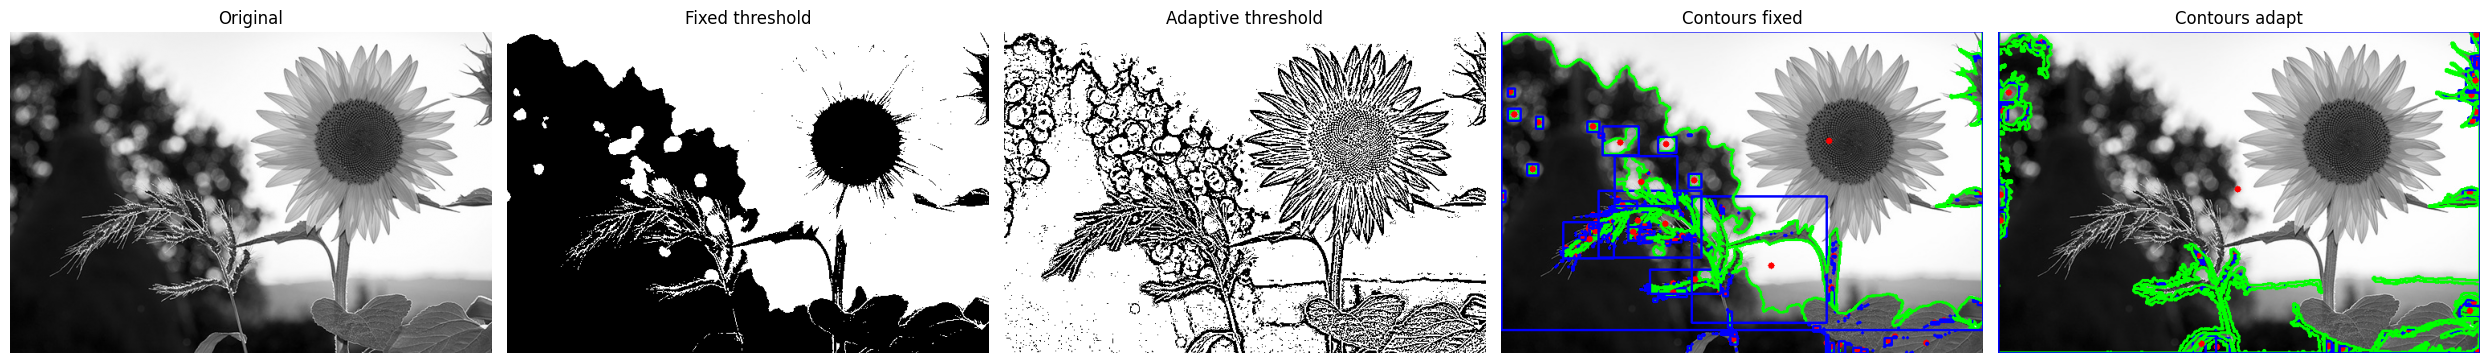

In [11]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import time
from IPython.display import display, clear_output

# Define working path and image file
# Detect current directory (where you started Jupyter) and build relative path
# Using parent if notebook is inside a subfolder
directorio_actual = Path.cwd().parent
print(f"Current directory: {directorio_actual}")

# Build path to 'image' folder and 'sunflower.jpg'
image_path = directorio_actual / 'image' / 'sunflower.jpg'
print(f"Full path to image: {image_path}")

# 1. Image processing functions
def load_image_gray(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {path}")
    return img


def fixed_threshold(img_gray: np.ndarray, thresh: float = 127, max_val: float = 255) -> np.ndarray:
    _, binary = cv2.threshold(img_gray, thresh, max_val, cv2.THRESH_BINARY)
    return binary


def adaptive_threshold(img_gray: np.ndarray,
                       max_val: float = 255,
                       method: int = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                       type_thresh: int = cv2.THRESH_BINARY,
                       block_size: int = 11,
                       C: int = 2) -> np.ndarray:
    return cv2.adaptiveThreshold(img_gray, max_val, method, type_thresh, block_size, C)


def find_contours(binary_img: np.ndarray) -> List[np.ndarray]:
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def compute_metrics(contours: List[np.ndarray]) -> Dict[str, Any]:
    num = len(contours)
    if num == 0:
        return {"num_shapes": 0, "avg_area": 0.0, "avg_perimeter": 0.0}
    areas = [cv2.contourArea(cnt) for cnt in contours]
    perimeters = [cv2.arcLength(cnt, True) for cnt in contours]
    return {"num_shapes": num, "avg_area": float(np.mean(areas)), "avg_perimeter": float(np.mean(perimeters))}


def draw_contours_and_metrics(image: np.ndarray, contours: List[np.ndarray]) -> np.ndarray:
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if image.ndim == 2 else image.copy()
    for cnt in contours:
        cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
        M = cv2.moments(cnt)
        if M.get("m00", 0) != 0:
            cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
            cv2.circle(output, (cx, cy), 4, (0, 0, 255), -1)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output, (x, y), (x+w, y+h), (255, 0, 0), 2)
    return output


def plot_images(images: Dict[str, np.ndarray]) -> None:
    plt.figure(figsize=(5*len(images),5))
    for idx, (title, img) in enumerate(images.items(),1):
        plt.subplot(1,len(images),idx)
        if img.ndim==2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout(); plt.show()

# 2. Process static image
img_gray = load_image_gray(image_path)
bin_fixed = fixed_threshold(img_gray)
bin_adapt = adaptive_threshold(img_gray)
cont_fixed = find_contours(bin_fixed)
cont_adapt = find_contours(bin_adapt)
met_fixed = compute_metrics(cont_fixed)
met_adapt = compute_metrics(cont_adapt)
print(f"Fixed -> shapes: {met_fixed['num_shapes']}, avg area: {met_fixed['avg_area']:.2f}, avg per: {met_fixed['avg_perimeter']:.2f}")
print(f"Adaptive -> shapes: {met_adapt['num_shapes']}, avg area: {met_adapt['avg_area']:.2f}, avg per: {met_adapt['avg_perimeter']:.2f}")
plot_images({
    'Original': img_gray,
    'Fixed threshold': bin_fixed,
    'Adaptive threshold': bin_adapt,
    'Contours fixed': draw_contours_and_metrics(img_gray, cont_fixed),
    'Contours adapt': draw_contours_and_metrics(img_gray, cont_adapt)
})

# 3. Webcam processing in notebook

def process_webcam_notebook(num_frames:int=100, delay:float=0.1):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened(): print("Cannot open camera"); return
    try:
        for _ in range(num_frames):
            ret, frame = cap.read()
            if not ret: break
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            binw = fixed_threshold(gray)
            cont = find_contours(binw)
            out = draw_contours_and_metrics(gray, cont)
            out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)
            plt.imshow(out_rgb); plt.axis('off'); plt.title('Webcam Contours'); plt.show()
            time.sleep(delay)
    finally:
        cap.release(); clear_output(wait=True); print("Webcam session ended.")

# To test webcam, uncomment:
# process_webcam_notebook()
